In [15]:
%load_ext autoreload
%autoreload 2

import torch
import torchaudio
import numpy as np
from torchaudio import functional as F
from torchaudio.utils import download_asset
from IPython import display
import scipy.signal as ss
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from src.herb.algorithm import get_audio_hat, dereverberate
from src.LP.algotithm import LP_dereverberation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Sample Data

In [16]:
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
sr = 16000

In [17]:
rir, rir_sr = torchaudio.load(SAMPLE_RIR)
rir = rir[:, int(rir_sr * 1.01) : int(rir_sr * 1.3)]
rir = rir / torch.linalg.vector_norm(rir, ord=2)
rir = torchaudio.transforms.Resample(rir_sr, sr)(rir)

display.Audio(rir, rate=sr)

In [18]:
speech, speech_sr = torchaudio.load(SAMPLE_SPEECH)
speech = torchaudio.transforms.Resample(speech_sr, sr)(speech)
display.Audio(speech, rate=sr)

In [19]:
augmented = F.fftconvolve(speech, rir)
display.Audio(augmented, rate=sr)

In [20]:
augmented = augmented.to(torch.float64).numpy().sum(axis=0)
augmented = augmented / np.abs(augmented).max()

#### Applying HERB

In [21]:
#result = get_audio_hat(augmented, augmented)
result,  spectr_filter = dereverberate(augmented, steps="full_filters")

[   0.     31.25   62.5    93.75  125.    156.25  187.5   218.75  250.
  281.25  312.5   343.75  375.    406.25  437.5   468.75  500.    531.25
  562.5   593.75  625.    656.25  687.5   718.75  750.    781.25  812.5
  843.75  875.    906.25  937.5   968.75 1000.   1031.25 1062.5  1093.75
 1125.   1156.25 1187.5  1218.75 1250.   1281.25 1312.5  1343.75 1375.
 1406.25 1437.5  1468.75 1500.   1531.25 1562.5  1593.75 1625.   1656.25
 1687.5  1718.75 1750.   1781.25 1812.5  1843.75 1875.   1906.25 1937.5
 1968.75 2000.   2031.25 2062.5  2093.75 2125.   2156.25 2187.5  2218.75
 2250.   2281.25 2312.5  2343.75 2375.   2406.25 2437.5  2468.75 2500.
 2531.25 2562.5  2593.75 2625.   2656.25 2687.5  2718.75 2750.   2781.25
 2812.5  2843.75 2875.   2906.25 2937.5  2968.75 3000.   3031.25 3062.5
 3093.75 3125.   3156.25 3187.5  3218.75 3250.   3281.25 3312.5  3343.75
 3375.   3406.25 3437.5  3468.75 3500.   3531.25 3562.5  3593.75 3625.
 3656.25 3687.5  3718.75 3750.   3781.25 3812.5  3843.75 3875.

In [22]:
result

array([0.00064244, 0.00068856, 0.00078099, ..., 0.00284263, 0.00293529,
       0.00295826])

In [23]:
display.Audio(result / np.abs(result).max(), rate=sr)

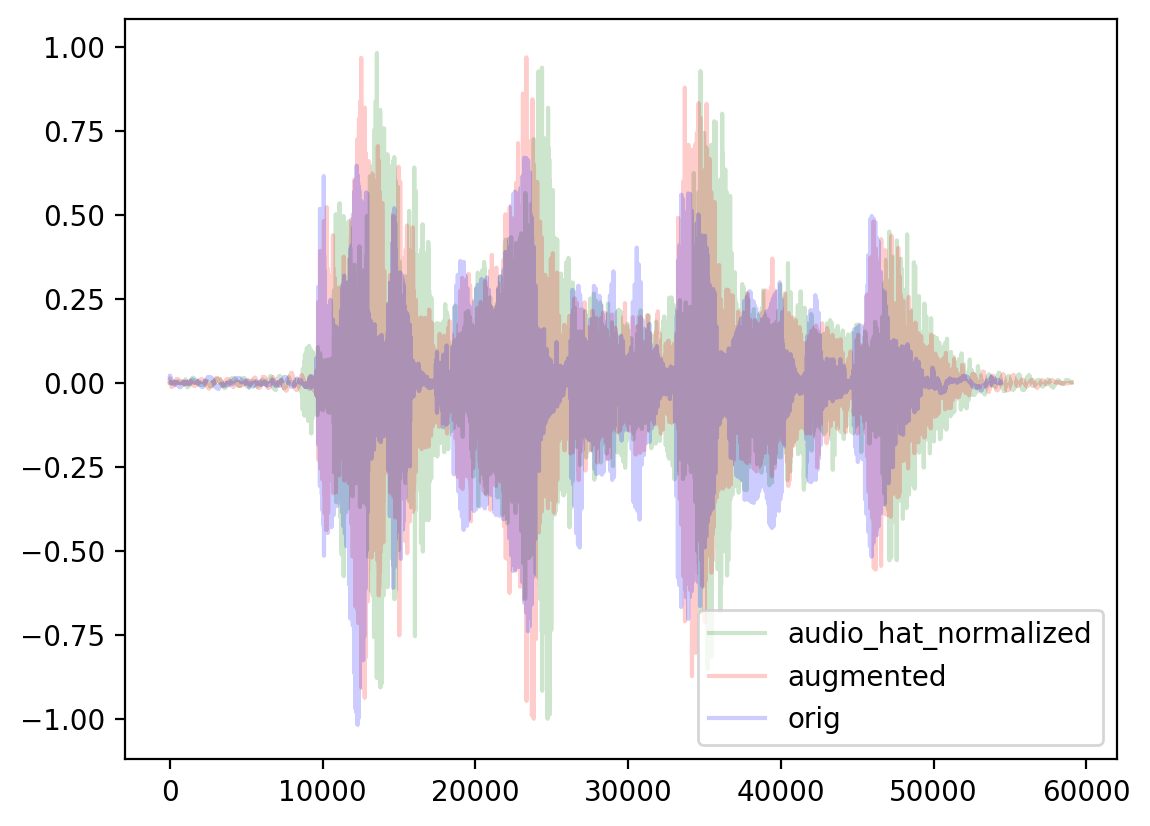

In [24]:
#plt.plot(result, color="blue", alpha=0.2, label="audio_hat")
plt.plot(result / np.abs(result).max(), color="green", alpha=0.2, label="audio_hat_normalized")
plt.plot(augmented, color="red", alpha=0.2, label="augmented")
plt.plot(speech[0].numpy(), color="blue", alpha=0.2, label="orig")
plt.legend()

##### T60

In [25]:
from pyroomacoustics.experimental.rt60 import measure_rt60

In [26]:
rir_numpy = rir[0].numpy()
rir_filtered = ss.convolve(rir_numpy, spectr_filter, mode="same")

(0.49925, 0.38362500000000005)

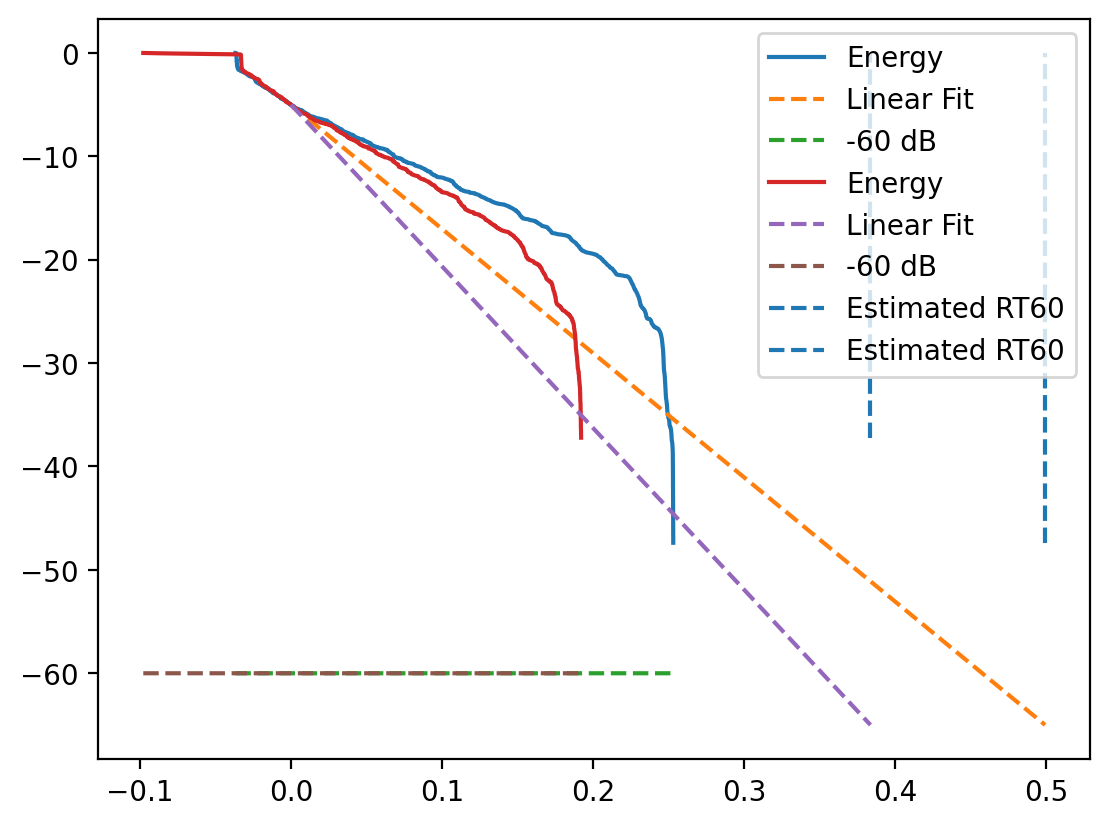

In [27]:
T60 = measure_rt60(rir_numpy, fs=16000, decay_db=30, plot=True)
filtered_T60 = measure_rt60(rir_filtered, fs=16000, decay_db=30, plot=True)

T60, filtered_T60

#### Applying LP


In [47]:
Lp_derev, LP_filt = LP_dereverberation(augmented, mu = 3e-9)

SyntaxError: invalid syntax (2798780300.py, line 1)

In [45]:
display.Audio(Lp_derev, rate=sr)    

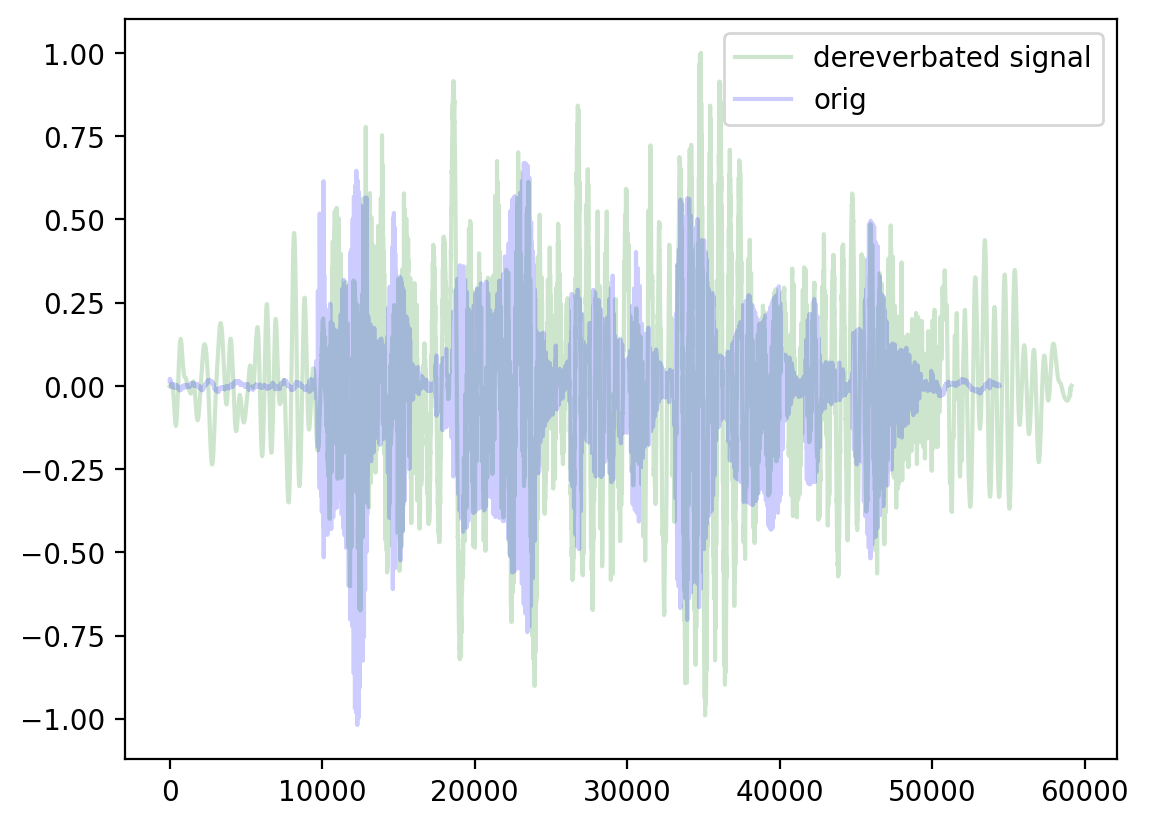

In [43]:
plt.plot(Lp_derev / np.abs(Lp_derev).max(), color="green", alpha=0.2, label="dereverbated signal")
#plt.plot(augmented, color="red", alpha=0.2, label="augmented")
plt.plot(speech[0].numpy(), color="blue", alpha=0.2, label="orig")

plt.legend()

#### T60 for LP

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.7029375, 0.32681249999999995)

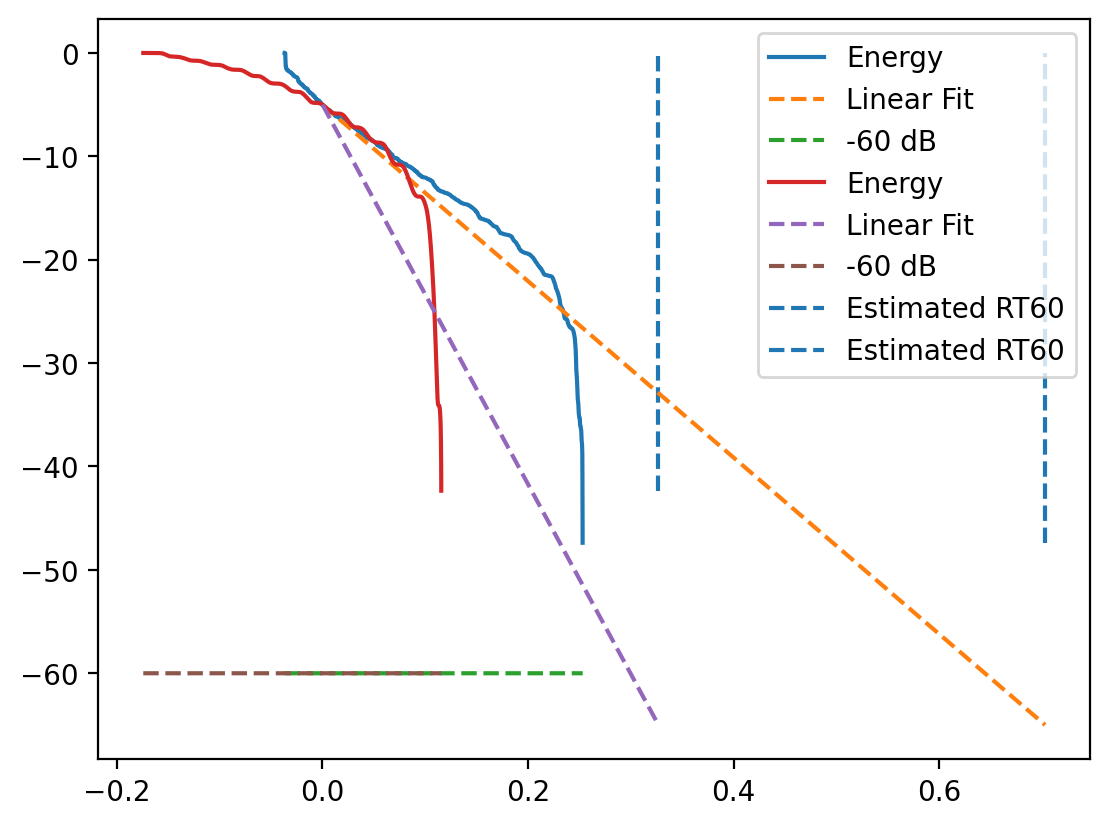

In [44]:
filtered_rir_lp = ss.lfilter(LP_filt, 1, rir_numpy)

T60 = measure_rt60(rir_numpy, fs=16000, decay_db=20, plot=True)
LP_filtered_T60 = measure_rt60(filtered_rir_lp, fs=16000, decay_db=20, plot=True)

T60, LP_filtered_T60